In [1]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import os
os.sys.path.extend(['../evaluation'])
from evaluate import model_preprocessed_filepath
import glob
from matplotlib import pyplot as plt
import math
%matplotlib inline

chencherry = SmoothingFunction().method2

In [2]:
def get_scores(filepath, subset='all-cat'):
    
    references_files = [f'../evaluation/references/{subset}_reference{i}.lex' for i in range(3)]
    hypothesis_file = filepath

    scores = []
    hypothesis = []
    references = []

    with open(references_files[0], 'r', encoding='utf-8') as ref0,\
         open(references_files[1], 'r', encoding='utf-8') as ref1,\
         open(references_files[2], 'r', encoding='utf-8') as ref2,\
         open(hypothesis_file, 'r', encoding='utf-8') as hyp:


        for h, r0, r1, r2 in zip(hyp, ref0, ref1, ref2):

            references.append((r0[:-1], r1[:-1], r2[:-1]))
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([r.split() for r in refs], 
                              hyp.split(), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores, hypothesis, references
    

def plot_hist_bleu(filepath, ax, subset='all-cat'):

    scores, _, _ = get_scores(filepath, subset)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)

In [3]:
def plot_all_models_hist_bleu(subset):
    
    models = [os.path.basename(s) for s in glob.glob('../data/models/*')]

    n_models = len(models)
    n_columns = 3
    n_rows = math.ceil(n_models / 3)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        try:
            filepath = model_preprocessed_filepath(model, subset)
        except FileNotFoundError as e:
            pass

        plot_hist_bleu(filepath, ax, subset)
        ax.set_title(model)

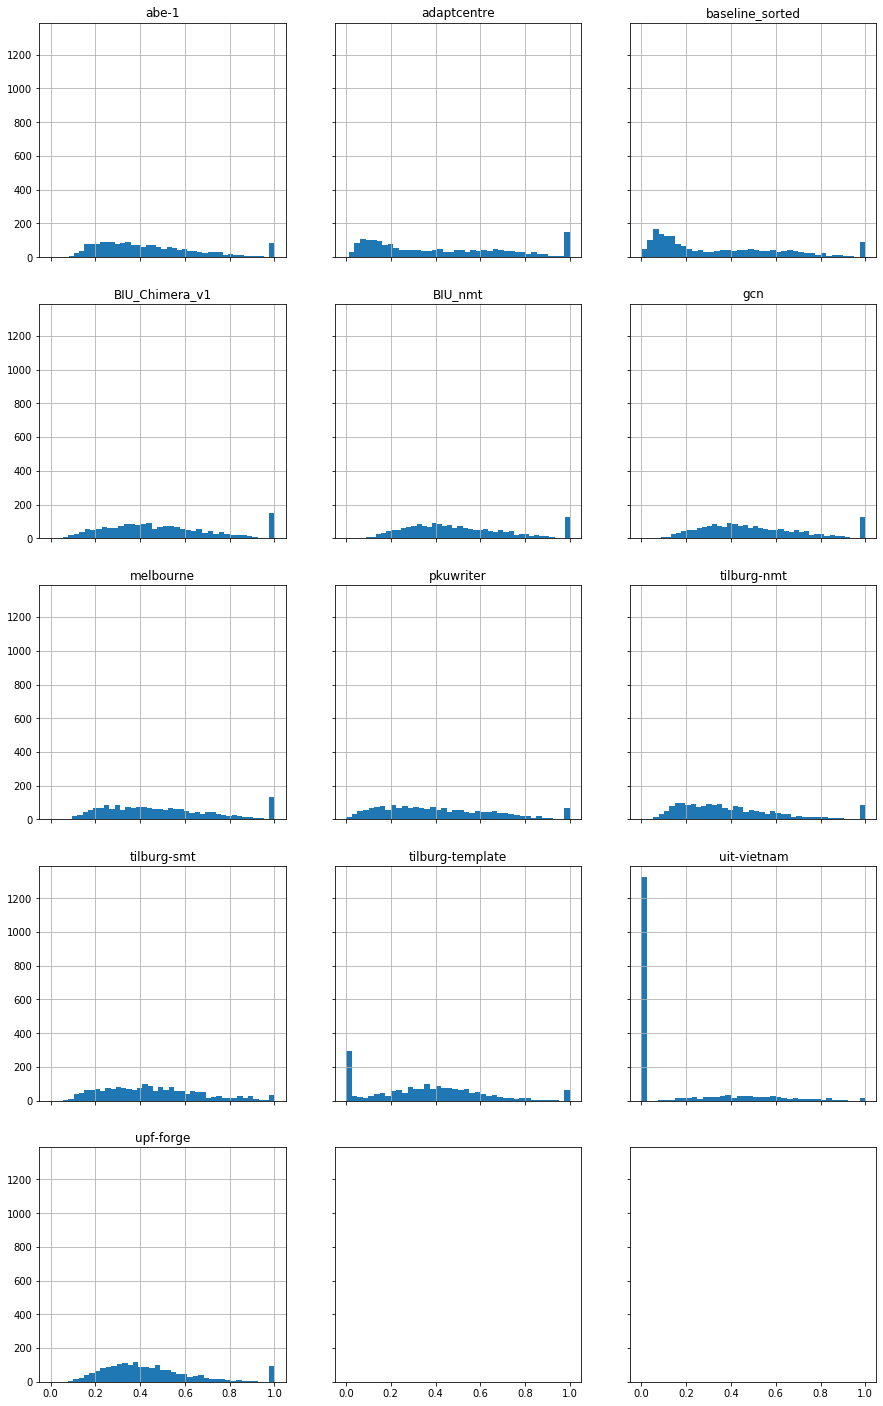

In [8]:
plot_all_models_hist_bleu('all-cat')

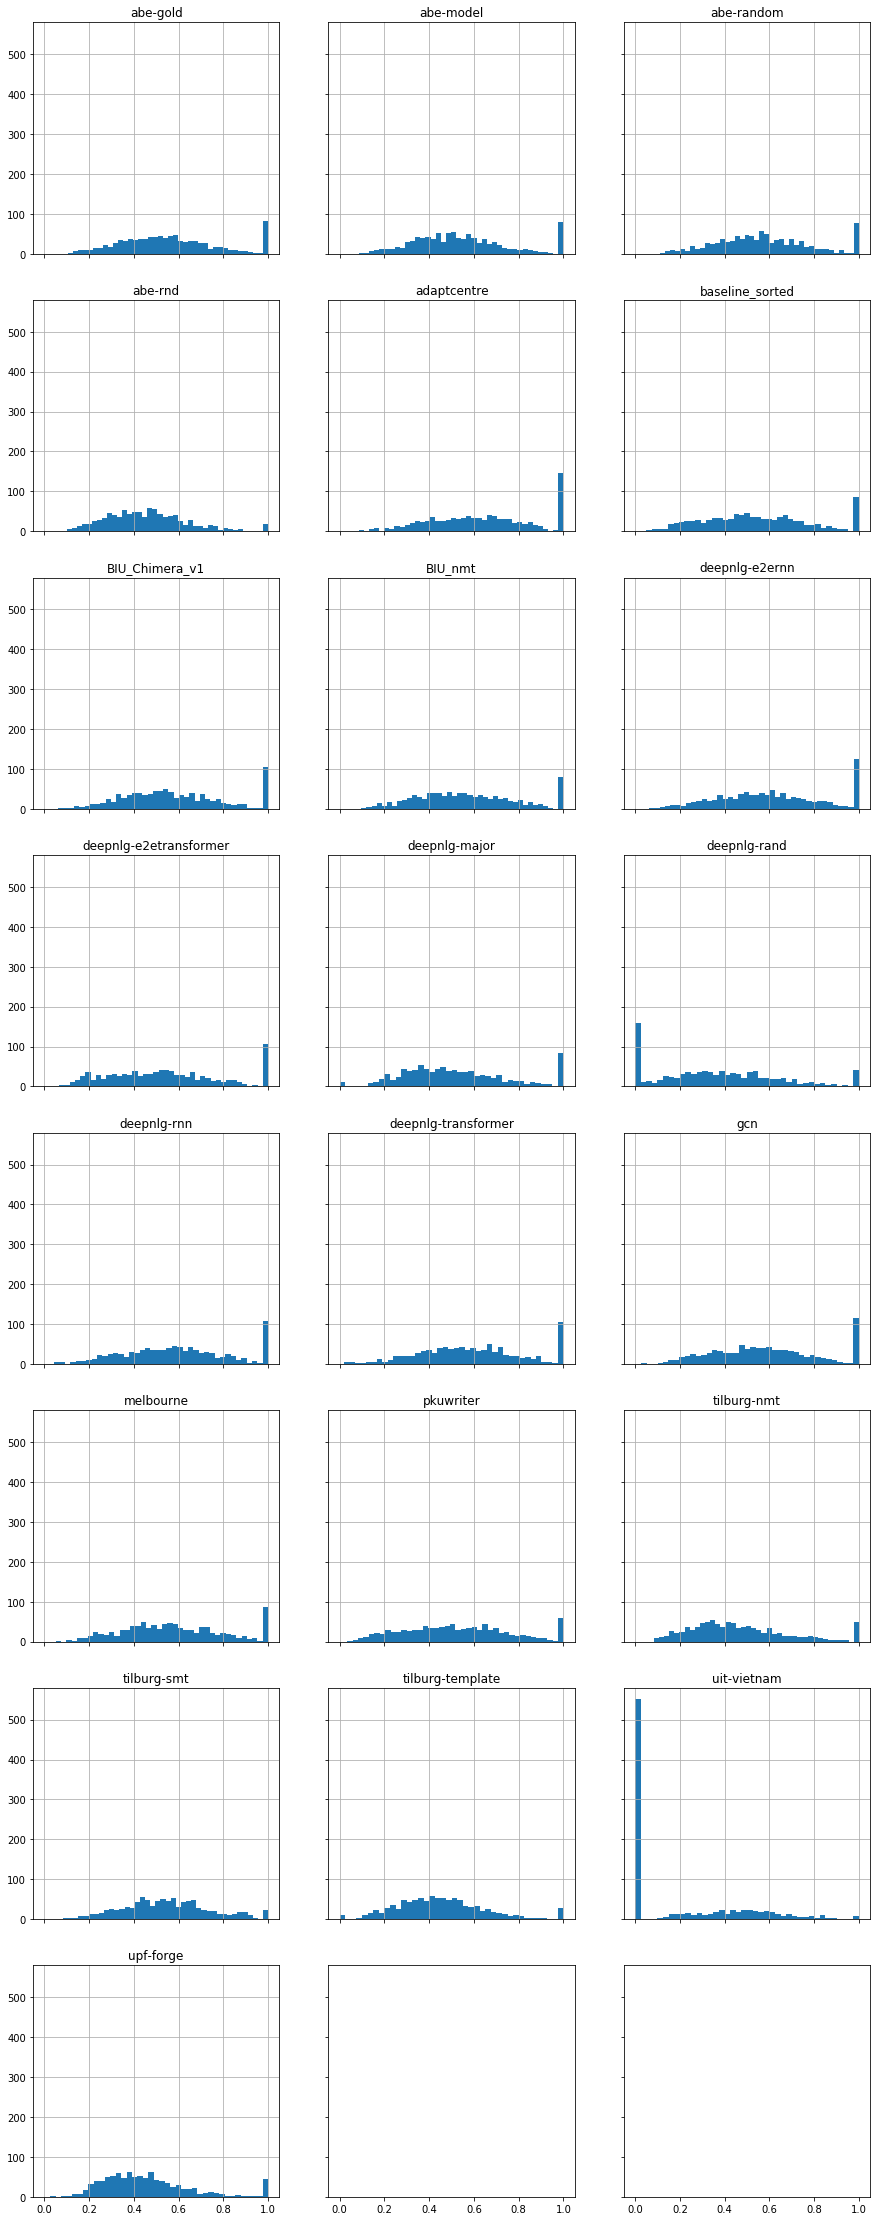

In [4]:
plot_all_models_hist_bleu('old-cat')

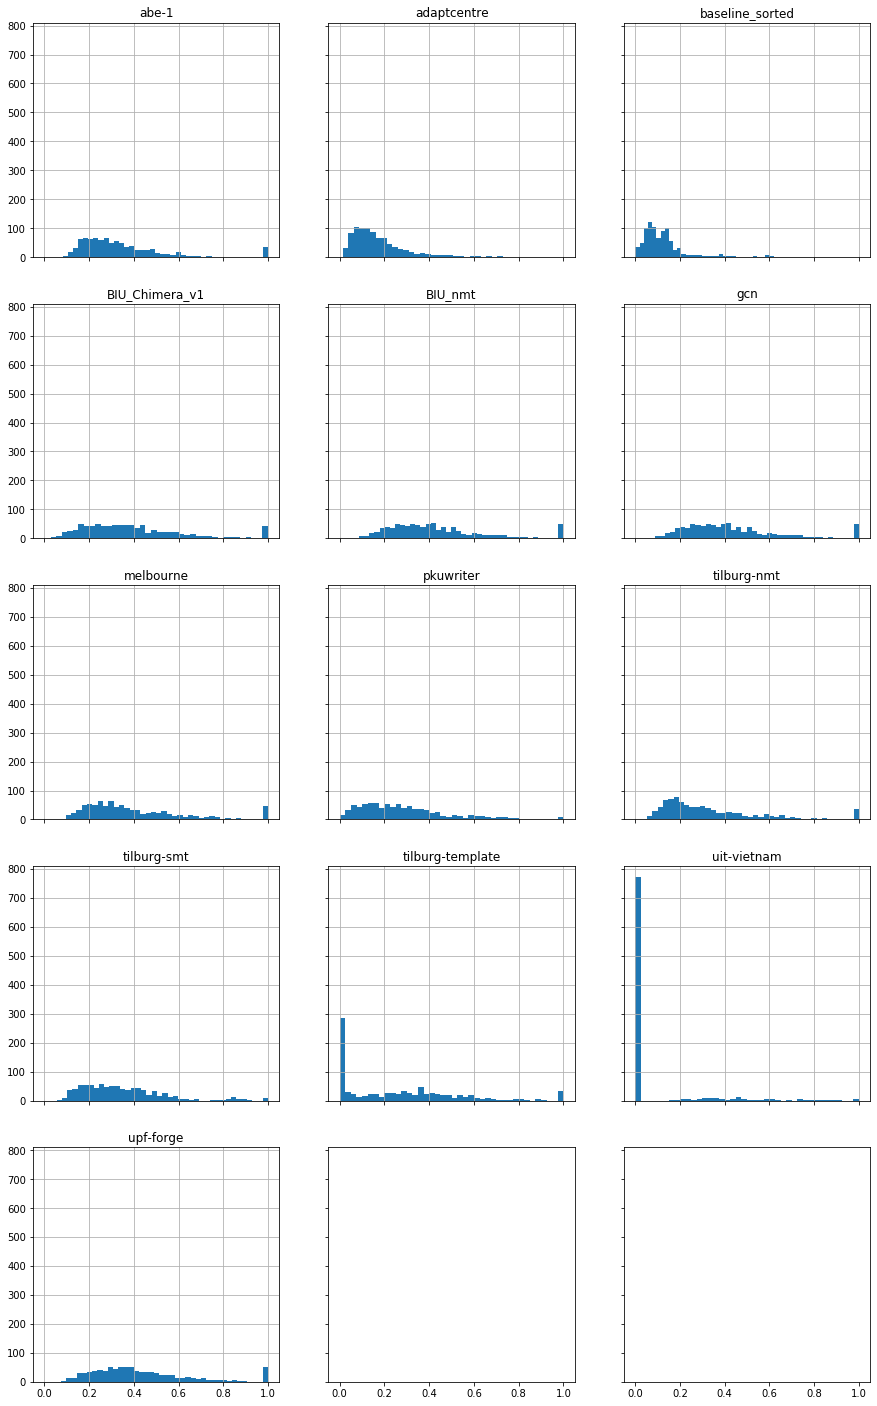

In [10]:
plot_all_models_hist_bleu('new-cat')

# Menores scores

In [4]:
models = ['abe-random', 'adaptcentre', 'gcn']

sc = {}
hyps = {}

for model in models:
    
    scores, hypothesis, _ = get_scores(model_preprocessed_filepath(model, 'old-cat'), 'old-cat')
    
    sc[f'{model}_bleu'] = scores
    hyps[f'{model}_hyp'] = hypothesis
    
data = {}
data.update(sc)
data.update(hyps)

In [5]:
import pandas as pd

pd.set_option('display.max_colwidth', 1000)

df = pd.DataFrame(data)

scores_cols = list(sc.keys())

df['mean_bleu'] = df[scores_cols].mean(axis=1)
df['min_bleu'] = df[scores_cols].min(axis=1)
df['max_bleu'] = df[scores_cols].max(axis=1)
df['range_bleu'] = df['max_bleu'] - df['min_bleu']
df['abe_to_max'] = df['max_bleu'] - df['abe-random_bleu']

In [6]:
df.sample().T

,225
abe-random_bleu,0.748797
adaptcentre_bleu,0.758826
gcn_bleu,0.569768
abe-random_hyp,the baku turkish martyrs ' memorial is dedicated to the ottoman army soldiers killed in the battle of baku and is called turk sehitleri aniti .
adaptcentre_hyp,the baku turkish martyrs memorial is dedicated to the ottoman army soldiers killed in the battle of baku and is known in name is turk sehitleri aniti .
gcn_hyp,the baku turkish martyrs memorial is dedicated to the ottoman army soldiers killed in the battle of baku and is dedicated to the ottoman army soldiers killed in the battle of baku .
mean_bleu,0.692464
min_bleu,0.569768
max_bleu,0.758826
range_bleu,0.189058


In [9]:
df[df.abe_to_max > 0.7].sample(3)

,abe-random_bleu,adaptcentre_bleu,gcn_bleu,abe-random_hyp,adaptcentre_hyp,gcn_hyp,mean_bleu,min_bleu,max_bleu,range_bleu,abe_to_max
163,0.231341,1.0,1.000000,amarillo occupies square kilometres 233 . 9 .,"amarillo , texas has a total area of 233 . 9 square kilometres .","amarillo , texas has a total area of 233 . 9 square kilometres .",0.743780,0.231341,1.0,0.768659,0.768659
1,0.219948,1.0,0.224671,adolfo suarez madrid - barajas airport is located there .,"adolfo suarez madrid - barajas airport can be found in madrid , paracuellos de jarama , san sebastian de los reyes and alcobendas .","the adolfo suárez madrid – barajas airport is in madrid , los reyes and paracuellos de jarama .",0.481540,0.219948,1.0,0.780052,0.780052
2,0.172555,1.0,1.000000,and is named 18l / 36r .,the runway name of adolfo suarez madrid - barajas airport is 18l / 36r .,the runway name of adolfo suarez madrid - barajas airport is 18l / 36r .,0.724185,0.172555,1.0,0.827445,0.827445


# Avaliando com textos gerados pelo template

In [3]:
import pickle

with open('../data/models/abe-2/milhoes_de_textos', 'rb') as f:
    references = pickle.load(f)

In [4]:
import re

c = re.compile(r'\W')

In [12]:
def get_scores(filepath):
    
    hypothesis_file = filepath

    scores = []
    hypothesis = []

    with open(hypothesis_file, 'r', encoding='utf-8') as hyp:

        for h in hyp:
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([c.split(r) for r in refs], 
                              c.split(hyp), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores
    

def plot_hist_bleu(filepath, ax):

    scores = get_scores(filepath)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)
    
def plot_all_models_hist_bleu(subset):
    
    models = [os.path.basename(s) for s in glob.glob('../data/models/*')]

    n_models = len(models)
    n_columns = 3
    n_rows = math.ceil(n_models / 3)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        filepath = model_preprocessed_filepath(model, subset)

        plot_hist_bleu(filepath, ax)
        ax.set_title(model)

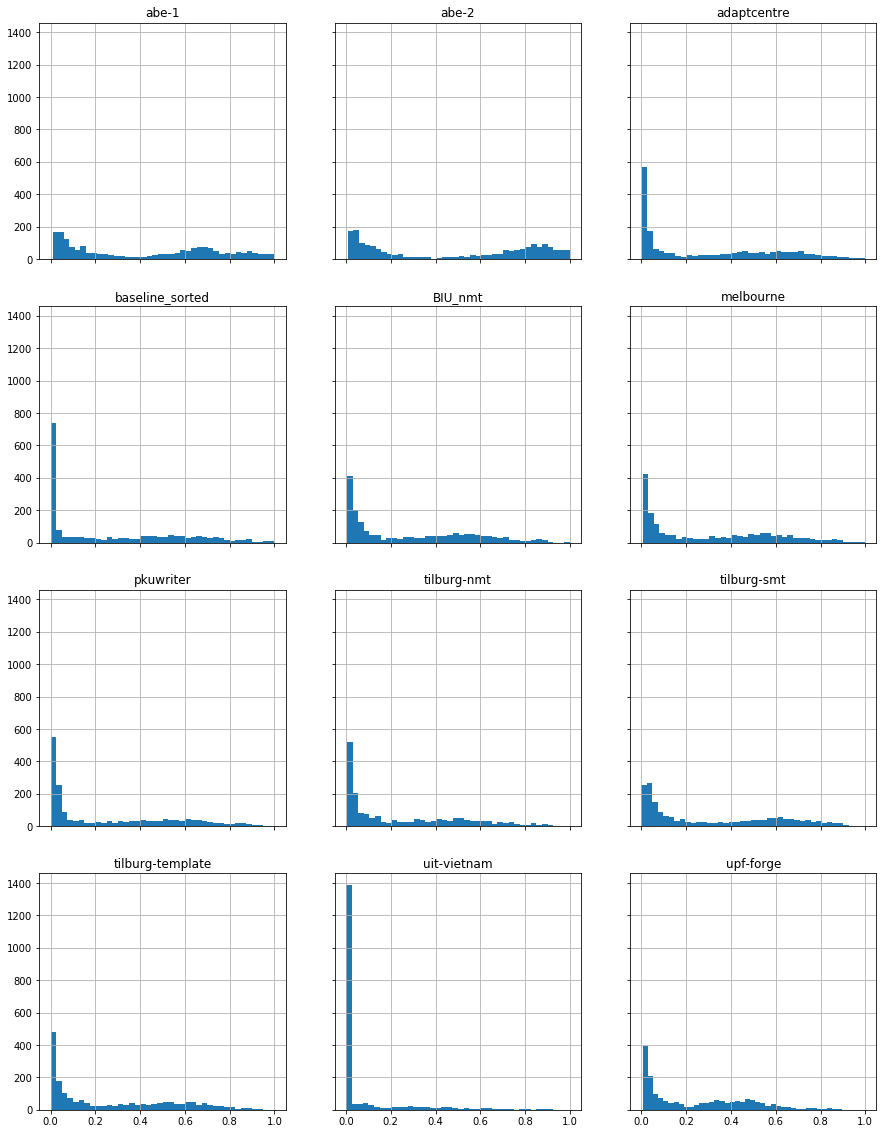

In [16]:
plot_all_models_hist_bleu('all-cat')